In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np

from gpytorch.means import Mean
import seaborn as sns
sns.set_style('white')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [2]:
class FeatureExtractor(torch.nn.Sequential):
    def __init__(self, widths=[50, 50]):
        super(FeatureExtractor, self).__init__()
        self.add_module('linear0', torch.nn.Linear(1, widths[0]))
        self.add_module('relu0', torch.nn.ReLU())
        for lyr in range(1, len(widths)):
            self.add_module('linear' + str(lyr), 
                            torch.nn.Linear(widths[lyr-1], widths[lyr]))
            self.add_module('relu' + str(lyr), torch.nn.ReLU())

        self.add_module('linear' + str(len(widths)+1), 
                        torch.nn.Linear(widths[-1], 1))



class NNMean(Mean):
    def __init__(self, input_size, batch_shape=torch.Size(), widths=[50,50]):
        super().__init__()
        self.net = FeatureExtractor(widths)
    
    def forward(self, x):
        return self.net(x).squeeze()


class NNGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, widths=[50,50]):
        super(NNGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = NNMean(train_x.shape[-1], widths)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    


In [3]:
torch.manual_seed(85234)
gen_lh = gpytorch.likelihoods.GaussianLikelihood()
gen_lh.noise = torch.tensor([0.02])
gen_model = ExactGPModel(None, None, gen_lh)
gen_model.covar_module.base_kernel.lengthscale = torch.tensor([0.75])
gen_model.eval();

In [4]:
ntest = 50
ntrain = 50

full_x = torch.linspace(0, 10, ntrain + ntest).unsqueeze(-1)

In [5]:
full_y = gen_lh(gen_model(full_x)).sample()

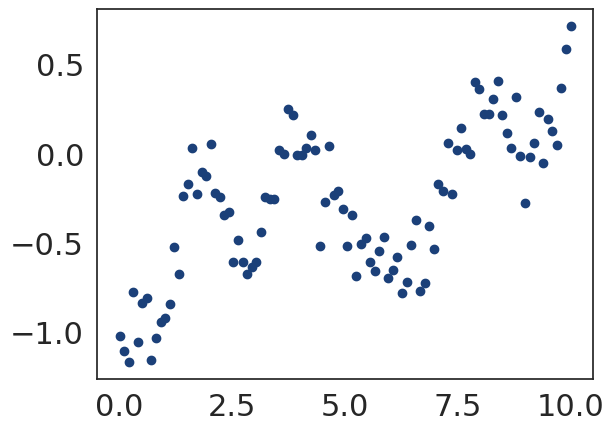

In [6]:
plt.scatter(full_x, full_y)

In [7]:
train_x = full_x[:ntrain]
train_y = full_y[:ntrain]
test_x = full_x[ntrain:]
test_y = full_y[ntrain:]

## Fit NN Model

In [8]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = NNGPModel(train_x, train_y, lh)

In [9]:
training_iter = 500

# Find optimal model hyperparameters
model.train()
lh.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/500 - Loss: 0.897   lengthscale: 0.693   noise: 0.693
Iter 51/500 - Loss: 0.685   lengthscale: 0.952   noise: 0.472
Iter 101/500 - Loss: 0.449   lengthscale: 1.260   noise: 0.304
Iter 151/500 - Loss: 0.199   lengthscale: 1.646   noise: 0.187
Iter 201/500 - Loss: -0.040   lengthscale: 2.000   noise: 0.113
Iter 251/500 - Loss: -0.266   lengthscale: 2.316   noise: 0.068
Iter 301/500 - Loss: -0.459   lengthscale: 2.604   noise: 0.042
Iter 351/500 - Loss: -0.615   lengthscale: 2.858   noise: 0.027
Iter 401/500 - Loss: -0.736   lengthscale: 3.062   noise: 0.019
Iter 451/500 - Loss: -0.797   lengthscale: 3.235   noise: 0.014


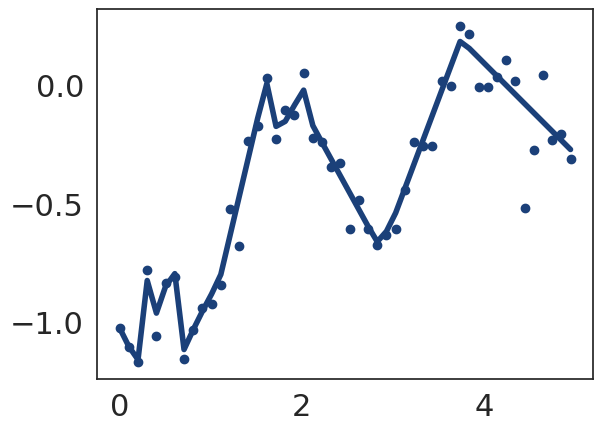

In [10]:
plt.plot(train_x, model(train_x).mean.detach())
plt.scatter(train_x, train_y)

In [11]:
lh.eval();
model.eval();

pred_ = model(full_x)
pred_lh_ = lh(pred_)
pred_mean = pred_.mean.detach()
pred_lower, pred_upper = pred_.confidence_region()

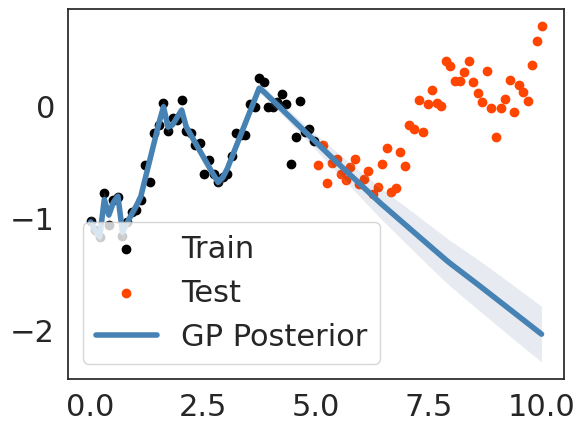

In [12]:
plt.scatter(train_x, train_y, label="Train", color='k')
plt.scatter(test_x, test_y, label="Test", color='OrangeRed')
plt.plot(full_x, pred_mean, label="GP Posterior", color='steelblue')
plt.fill_between(full_x.squeeze(), pred_lower.detach(), pred_upper.detach(),
                alpha=0.1)
plt.legend()

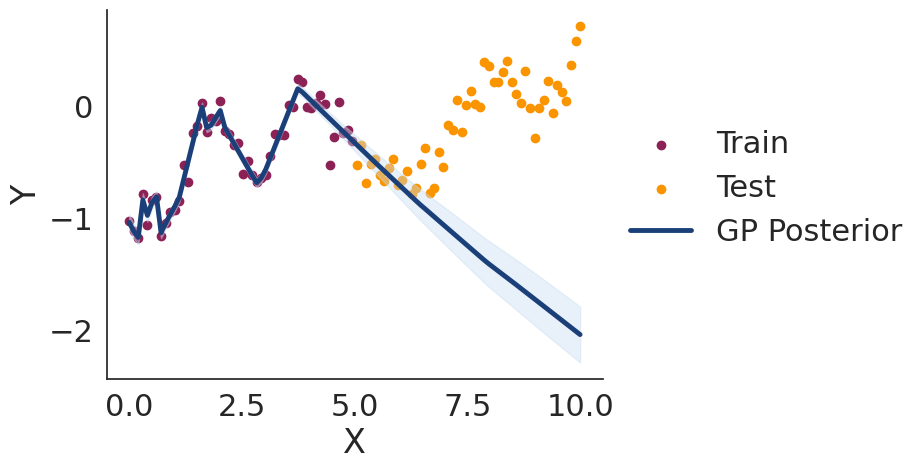

In [13]:
plt.scatter(train_x, train_y, label="Train", color=palette[4])
plt.scatter(test_x, test_y, label="Test", color=palette[7])
plt.plot(full_x, pred_mean, label="GP Posterior", color=palette[0],
        lw=3.5)
plt.fill_between(full_x.squeeze(), pred_lower.detach(), pred_upper.detach(),
                alpha=0.4, color=palette[1])
plt.legend(bbox_to_anchor=(1., 0.75),
          frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
plt.savefig("./gp-overfitting.pdf", bbox_inches='tight')

In [14]:
np.savez("../../plots/data/gp_mean_overfitting.npz",
         train_x=train_x.detach().numpy()[:, 0],
         train_y=train_y.detach().numpy(),
         test_x=test_x.detach().numpy()[:, 0],
         test_y=test_y.detach().numpy(),
         full_x=full_x.detach().numpy()[:, 0],
         pred_mean=pred_mean.detach().numpy(),
         pred_sigma=pred_.stddev.detach().numpy(),
         pred_sigma_wnoise=pred_lh_.stddev.detach().numpy(),
        )

## Regular GP

In [15]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, lh)

In [16]:
training_iter = 500

# Find optimal model hyperparameters
model.train()
lh.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/500 - Loss: 0.903   lengthscale: 0.693   noise: 0.693
Iter 51/500 - Loss: 0.709   lengthscale: 0.910   noise: 0.472
Iter 101/500 - Loss: 0.523   lengthscale: 0.895   noise: 0.308
Iter 151/500 - Loss: 0.331   lengthscale: 0.726   noise: 0.194
Iter 201/500 - Loss: 0.150   lengthscale: 0.658   noise: 0.121
Iter 251/500 - Loss: -0.005   lengthscale: 0.624   noise: 0.076
Iter 301/500 - Loss: -0.128   lengthscale: 0.612   noise: 0.050
Iter 351/500 - Loss: -0.211   lengthscale: 0.606   noise: 0.035
Iter 401/500 - Loss: -0.257   lengthscale: 0.599   noise: 0.026
Iter 451/500 - Loss: -0.277   lengthscale: 0.591   noise: 0.022


In [17]:
lh.eval();
model.eval();

pred_ = model(full_x)
pred_lh_ = lh(pred_)
pred_mean = pred_.mean.detach()
pred_lower, pred_upper = pred_.confidence_region()

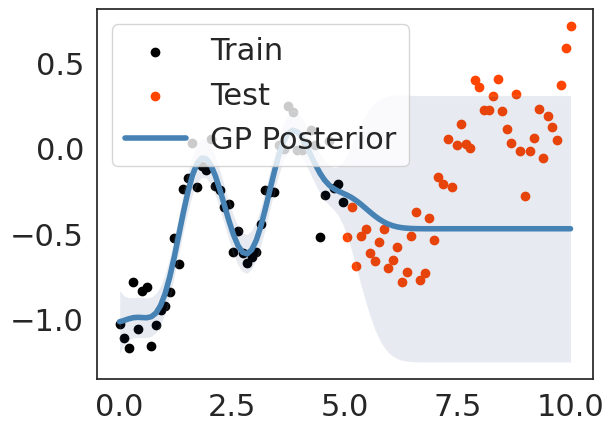

In [18]:
plt.scatter(train_x, train_y, label="Train", color='k')
plt.scatter(test_x, test_y, label="Test", color='OrangeRed')
plt.plot(full_x, pred_mean, label="GP Posterior", color='steelblue')
plt.fill_between(full_x.squeeze(), pred_lower.detach(), pred_upper.detach(),
                alpha=0.1)
plt.legend()

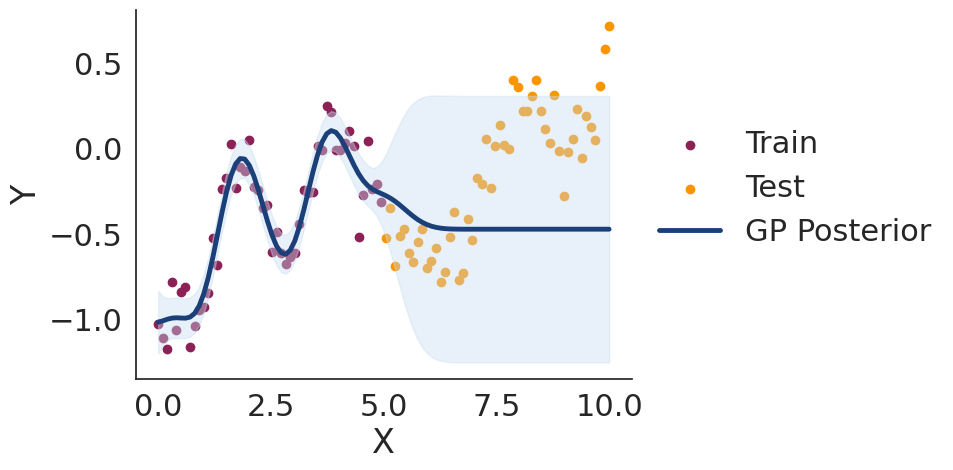

In [19]:
plt.scatter(train_x, train_y, label="Train", color=palette[4])
plt.scatter(test_x, test_y, label="Test", color=palette[7])
plt.plot(full_x, pred_mean, label="GP Posterior", color=palette[0],
        lw=3.5)
plt.fill_between(full_x.squeeze(), pred_lower.detach(), pred_upper.detach(),
                alpha=0.4, color=palette[1])
plt.legend(bbox_to_anchor=(1., 0.75),
          frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
plt.savefig("./gp-overfitting.pdf", bbox_inches='tight')

In [20]:
np.savez("../../plots/data/gp_mean_overfitting_baseline.npz",
         train_x=train_x.detach().numpy()[:, 0],
         train_y=train_y.detach().numpy(),
         test_x=test_x.detach().numpy()[:, 0],
         test_y=test_y.detach().numpy(),
         full_x=full_x.detach().numpy()[:, 0],
         pred_mean=pred_mean.detach().numpy(),
         pred_sigma=pred_.stddev.detach().numpy(),
         pred_sigma_wnoise=pred_lh_.stddev.detach().numpy(),
        )

## Analysis

In [21]:
print(gen_model.covar_module.base_kernel.lengthscale)
print(model.covar_module.base_kernel.lengthscale)

tensor([[0.7500]], grad_fn=<SoftplusBackward0>)
tensor([[0.5838]], grad_fn=<SoftplusBackward0>)


In [22]:
print(gen_model.likelihood.noise)
print(model.likelihood.noise)

tensor([0.0200], grad_fn=<AddBackward0>)
tensor([0.0195], grad_fn=<AddBackward0>)


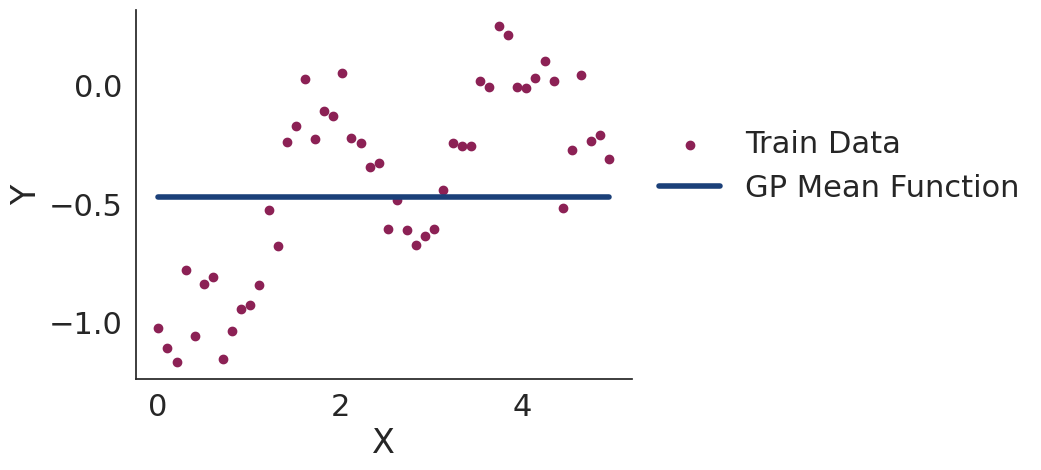

In [23]:
plt.scatter(train_x, train_y, label="Train Data", color=palette[4])
plt.plot(train_x, model.mean_module(train_x).detach(), label="GP Mean Function", color=palette[0])
plt.legend(bbox_to_anchor=(1., 0.75),
          frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
plt.savefig("./gp-overfitting.jpg", bbox_inches='tight')